           ont_contam  hifi_contam hifi_center ont_center       value   
SIN                                                                     
SIN:00171      0.0141       0.0040          UW         UW  48294212.0  \
SIN:00268      0.0178       0.0043         JAX        JAX   2818605.0   
SIN:00358      0.0155       0.0045         JAX        JAX   3952204.0   
SIN:00733      0.0207       0.0036          UW        MIX   7061978.0   
SIN:01114      0.0141       0.0050          UW         UW  33062969.0   
SIN:01352      0.0207       0.0047          UW         UW   2274549.0   
SIN:01457      0.0197       0.0038         JAX        JAX   3940399.0   
SIN:01505      0.0147       0.0037         JAX        JAX   3168178.0   
SIN:01573      0.0133       0.0047          UW         UW  26590008.0   
SIN:02018      0.0164       0.0039          UW         UW  81514565.0   
SIN:02059      0.0199       0.0051          UW         UW   5672266.0   
SIN:02106      0.0186       0.0039         JAX     

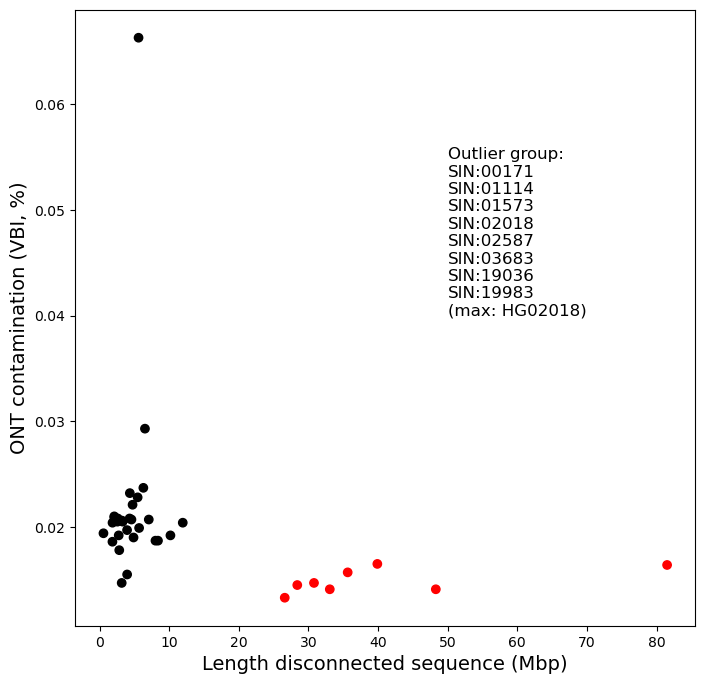

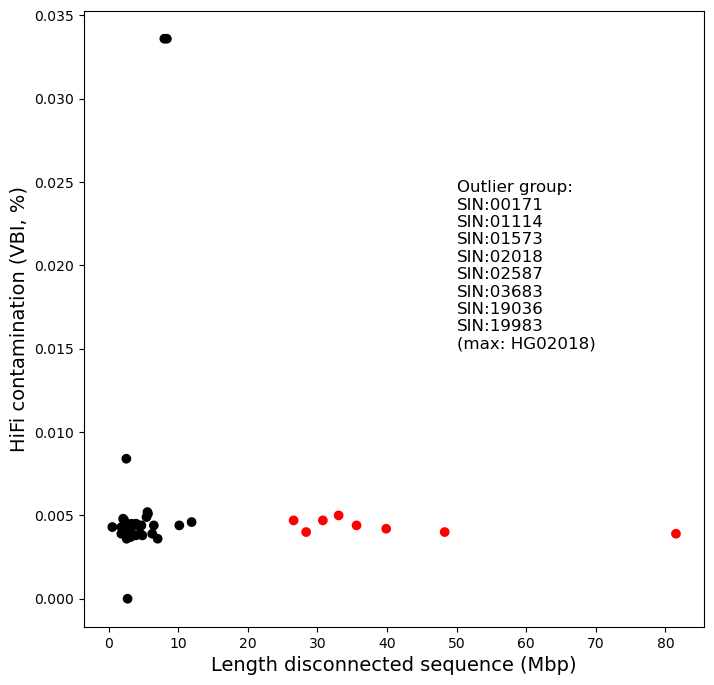

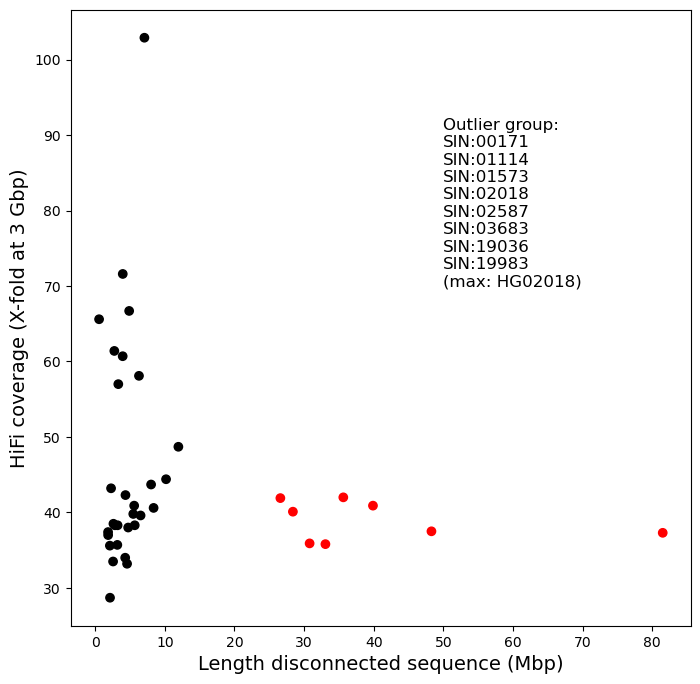

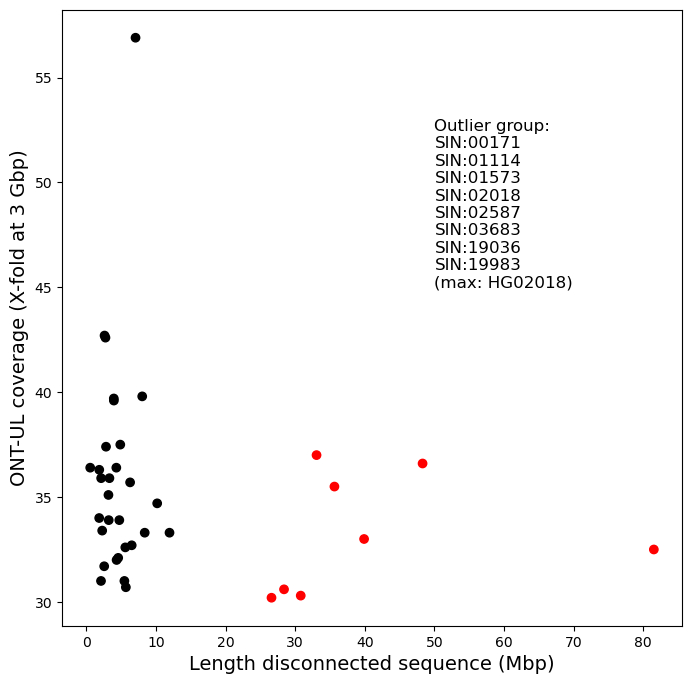

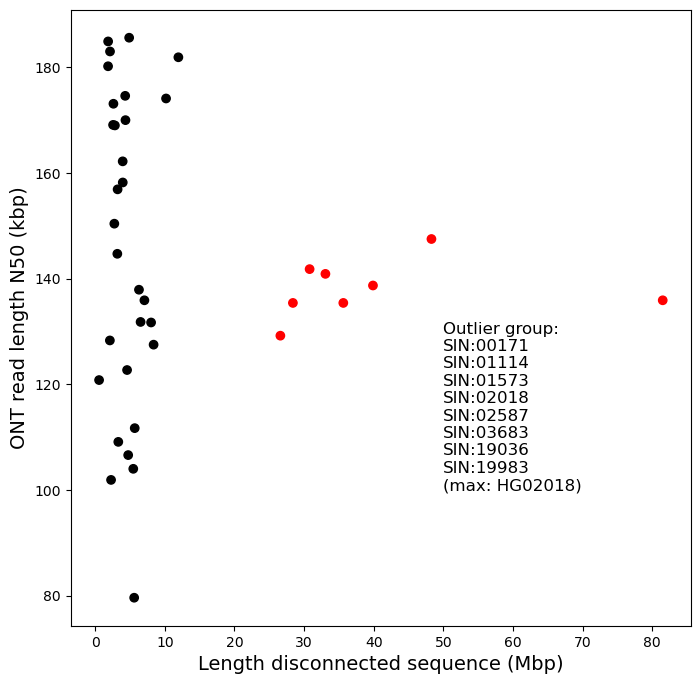

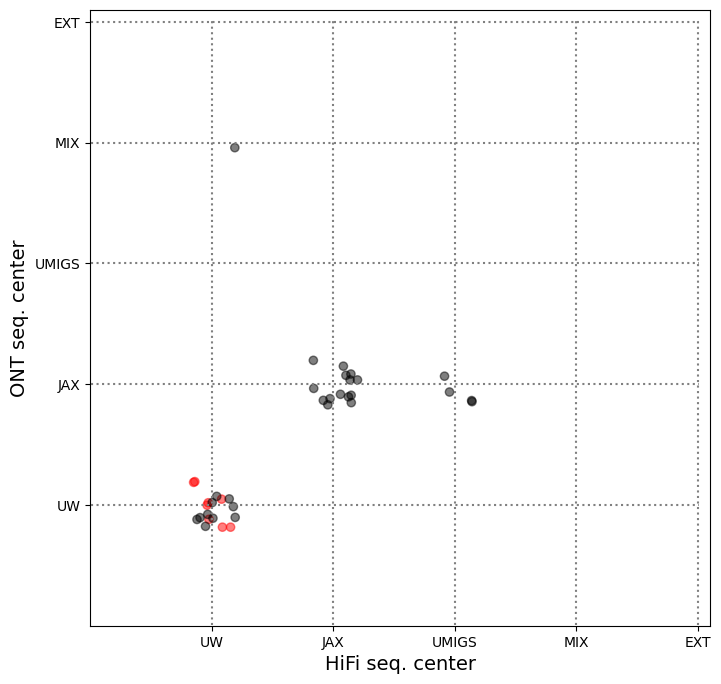

In [81]:
import pandas as pd
import pathlib as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
import random as rand
import collections as col

rand.seed()

assm_stats_file = pl.Path(
    "/home/ebertp/work/projects/hgsvc/2023_assm_stats/verkko",
    "assembly_stats_all.verkko.sseq.tsv"
)

assm_stats = pd.read_csv(assm_stats_file, sep="\t", comment="#", header=0)
assm_stats["SIN"] = "SIN:" + assm_stats["sample"].str.extract("([0-9]+)")

disconn = assm_stats.loc[assm_stats["assembly_unit"] == "disconnected", :].copy()
disc_len = disconn.loc[disconn["statistic"] == "total_length_grt_0bp", :].copy()
disc_len.index = disc_len["SIN"]
disc_len.drop(["sample", "SIN"], axis=1, inplace=True)


select_read_stats = [
    "cov_xfold_grt_0bp_at_3Gbp",
    "cov_xfold_grt_15kbp_at_3Gbp",
    "cov_xfold_grt_100kbp_at_3Gbp",
    "length_N50_grt_0bp",
    "length_N50_grt_100kbp"
]

read_stats_file = pl.Path(
    "/home/ebertp/work/projects/hgsvc/2023_batch_data_tables",
    "hgsvc3_batch1_read_stats.tsv"
)
read_stats = pd.read_csv(read_stats_file, comment="#", header=0, sep="\t")
read_stats = read_stats.loc[read_stats["source"] == "all", :].copy()
read_stats = read_stats.loc[read_stats["statistic"].isin(select_read_stats), :]
read_stats["SIN"] = "SIN:" + read_stats["sample"].str.extract("([0-9]+)")
read_stats.index = read_stats["SIN"]
read_stats.drop(["SIN", "sample", "source"], axis=1, inplace=True)


sample_contam_file = pl.Path(
    "/home/ebertp/work/code/cubi/project-run-hgsvc-hybrid-assemblies/annotations/projectmng",
    "hgsvc_contaminations.tsv"
)

sample_contam = pd.read_csv(sample_contam_file, sep="\t", comment="#", header=0)
sample_contam["SIN"] = "SIN:" + sample_contam["sample"].str.extract("([0-9]+)")
sample_contam = sample_contam.loc[sample_contam["SIN"].isin(assm_stats["SIN"]), :].copy()

sample_contam.index = sample_contam["SIN"]
sample_contam.drop(["sample", "SIN"], axis=1, inplace=True)

merged = sample_contam.join(disc_len)
merged.drop(["assembly_unit", "statistic"], axis=1, inplace=True)
merged["disc_len_Mbp"] = (merged["value"] / 1e6).round(2)
merged.sort_index(inplace=True)
print(merged)

sample_colors = [
    "red" if row.disc_len_Mbp > 20 else "black" for row in merged.itertuples()
]
sample_order = merged.index.values

outlier_samples = set(row.Index if row.disc_len_Mbp > 20 else "" for row in merged.itertuples())
print(sorted(outlier_samples))

color_lut = dict((s, c) for s, c in zip(sample_order, sample_colors))

outlier_text = [s for s, c in zip(sample_order, sample_colors) if c == "red"]
outlier_text = "\n".join(["Outlier group:"] + outlier_text)
outlier_text += "\n(max: HG02018)"

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(
    merged["disc_len_Mbp"],
    merged["ont_contam"],
    c=sample_colors
)
ax.set_xlabel("Length disconnected sequence (Mbp)", fontsize=14)
ax.set_ylabel("ONT contamination (VBI, %)", fontsize=14)

ax.text(50, 0.04, outlier_text, fontsize=12)

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(
    merged["disc_len_Mbp"],
    merged["hifi_contam"],
    c=sample_colors
)
ax.set_xlabel("Length disconnected sequence (Mbp)", fontsize=14)
ax.set_ylabel("HiFi contamination (VBI, %)", fontsize=14)

ax.text(50, 0.015, outlier_text, fontsize=12)

fig, ax = plt.subplots(figsize=(8, 8))

hifi_cov = read_stats.loc[
    (read_stats["read_type"] == "hifi") & (read_stats["statistic"] == "cov_xfold_grt_0bp_at_3Gbp"),
    :
].copy()

ax.scatter(
    merged["disc_len_Mbp"],
    hifi_cov.loc[sample_order, "value"].values,
    c=sample_colors
)
ax.set_xlabel("Length disconnected sequence (Mbp)", fontsize=14)
ax.set_ylabel("HiFi coverage (X-fold at 3 Gbp)", fontsize=14)

ax.text(50, 70, outlier_text, fontsize=12)

fig, ax = plt.subplots(figsize=(8, 8))

ontul_cov = read_stats.loc[
    (read_stats["read_type"] == "ont") & (read_stats["statistic"] == "cov_xfold_grt_100kbp_at_3Gbp"),
    :
].copy()

ax.scatter(
    merged["disc_len_Mbp"],
    ontul_cov.loc[sample_order, "value"].values,
    c=sample_colors
)
ax.set_xlabel("Length disconnected sequence (Mbp)", fontsize=14)
ax.set_ylabel("ONT-UL coverage (X-fold at 3 Gbp)", fontsize=14)

ax.text(50, 45, outlier_text, fontsize=12)

fig, ax = plt.subplots(figsize=(8, 8))

ontul_n50 = read_stats.loc[
    (read_stats["read_type"] == "ont") & (read_stats["statistic"] == "length_N50_grt_0bp"),
    :
].copy()

ax.scatter(
    merged["disc_len_Mbp"],
    (ontul_n50.loc[sample_order, "value"].values / 1000).round(1),
    c=sample_colors
)
ax.set_xlabel("Length disconnected sequence (Mbp)", fontsize=14)
ax.set_ylabel("ONT read length N50 (kbp)", fontsize=14)

ax.text(50, 100, outlier_text, fontsize=12)

tick_locs = list(range(1,6))
ticklabels = ["UW", "JAX", "UMIGS", "MIX", "EXT"]

center_point_map = dict((label, loc) for label, loc in zip(ticklabels, tick_locs))

fig, ax = plt.subplots(figsize=(8, 8))

x_vals = []
y_vals = []
colors = []

def add_jitter(point):
    
    jitter = rand.uniform(-0.2, 0.2)
    return round(point + jitter, 3), point

center_probs = col.Counter()

for row in sample_contam.itertuples(index=True):
    x_coord, x_prec = add_jitter(center_point_map[row.hifi_center])
    y_coord, y_prec = add_jitter(center_point_map[row.ont_center])
    x_vals.append(x_coord)
    y_vals.append(y_coord)
    colors.append(color_lut[row.Index])
    center_probs[(x_prec, y_prec)] += 1
    
ax.scatter(
    x_vals,
    y_vals,
    c=colors,
    alpha=0.5
)
ax.set_xticks(tick_locs)
ax.set_xticklabels(ticklabels, fontsize=10)
ax.set_xlim(0, 5.1)

ax.set_yticks(tick_locs)
ax.set_yticklabels(ticklabels, fontsize=10)
ax.set_ylim(0, 5.1)

ax.vlines(tick_locs, 0.01, 5.01, colors="grey", linestyle="dotted", zorder=3)
ax.hlines(tick_locs, 0.01, 5.01, colors="grey", linestyle="dotted", zorder=3)

ax.set_xlabel("HiFi seq. center", fontsize=14)
ax.set_ylabel("ONT seq. center", fontsize=14)

print(center_probs)
total_samples = sum(center_probs.values())

for k, v in center_probs.items():
    print(k, " - ", v, " --- ", round(v/total_samples*100, 1))